# SimMETIS: N-band Imaging - Flux Tests

In this notebook we compute photon fluxes, i.e. we do not take the detector QE into account. The notebook looks at background and source fluxes computed with SimMETIS and compares them to other estimates for the purpose of cross-validation. The notebook also shows how to simulate a chopped observation of a point source.

We start by importing packages and functions that will be useful.

In [1]:
import numpy as np
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
from astropy import constants as const
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

Finally, we import simmetis and check the versions of simmetis and required packages (remember to include the output of `sim.bug_report()` whenever you report bugs or problems to the developers).

In [2]:
import simmetis as sim
sim.bug_report()

Optional package wget is not installed:
       simmetis.get_extras() will not work.
Python:
 3.9.1+ (default, Feb  5 2021, 13:46:56) 
[GCC 10.2.1 20210110]

simmetis :  0.3rc1
astropy :  4.2
synphot :  1.0.1
numpy :  1.19.4
scipy :  1.5.4
poppy could not be loaded.
wget could not be loaded.

Operating system:  Linux
         Release:  5.10.0-3-amd64
         Version:  #1 SMP Debian 5.10.13-1 (2021-02-06)
         Machine:  x86_64


### Number of photons generated in M1 space

We first compute the number of photons in M1 space, i.e. the thermal emission from the telescope (at a typical temperature of 9 °C), from basic considerations. We use the basic characteristics of the ELT and METIS with the N2 filter and GeoSnap detector. 

In [3]:
# ELT light collecting area, thermal emissivity:
area_ELT = np.pi * ((38 / 2 * u.m)**2 - (11.1 / 2 * u.m)**2)
emissivity_M1 = 0.23                # total emissivity of ELT according to ESO ICD
emissivity_M1_with_spiders = 0.267  # total emissivity of ELT according to Roy van Boekel

# N2 filter:
eff_wave = 11.5 * u.micron
N2_edges = [10.12, 13.13]
bandwidth = (np.diff(N2_edges)[0]) * u.micron

# pixel area on the sky
solid_angle = (0.00679 * u.arcsecond)**2

# photon energy
e_phot = const.h * const.c / eff_wave
r = blackbody_lambda(eff_wave, 282 * u.K)

n_ph_per_s = emissivity_M1_with_spiders * r * bandwidth * area_ELT * solid_angle / e_phot

print("Expected: The number of photons emitted from M1 per second per pixel is {0:.2E}".format(n_ph_per_s.si.value))

Expected: The number of photons emitted from M1 per second per pixel is 3.71E+08


Now compare this number to what SimMETIS computes.

In [4]:
from simmetis.spectral import BlackbodyCurve as sim_bb

In [5]:
## the wave array needs to have > 2 elements, otherwise edge effects 
## make the number of photons a factor of 2 too large
wave_array = np.arange(N2_edges[0], N2_edges[1], 0.01)

In [6]:
em = sim_bb(wave_array, 282 - 273.15, pix_res=0.00679, area=area_ELT.value)
em_n_ph = emissivity_M1_with_spiders * em.photons_in_range()
print("SimMETIS: The number of photons emitted from M1 per second per pixel is \
{0:.2E}".format(em_n_ph))

SimMETIS: The number of photons emitted from M1 per second per pixel is 3.69E+08


The two numbers are identical. Yay!

Now compare this number to what Roy van Boekel computed in E-TNT-MPIA-MET-1004 (v1.0). 

In [10]:
# to compare to Roy's number the number above needs to be corrected for 
#    - contribution by atmosphere (10%)
#    - contribution by the entrance window (10%)
#    - transmission of N2 filter (36%/77%); divided by transmission of telescope (which is included in the
#      emissivity)
# We thus arrive at
print(n_ph_per_s.decompose())
n_ph_per_s_det = n_ph_per_s * 1.1 * 1.1 * 0.356 / 0.77
print("Expected: The number of photons arriving at the detector per second per pixel is {0:.2E}"
      .format(n_ph_per_s_det.decompose().value))

370977095.51542604 1 / s
Expected: The number of photons arriving at the detector per second per pixel is 2.08E+08


This number is essentially compatible with Roy's fluxes document (v0.8, Table 4, N2 filter, median conditions) where 5.5e8 photons are given. This number was computed for the AQUARIUS detector with 10.78 mas pixel scale and needs to be rescaled to the GeoSnap detector with 6.79 mas, resulting in 2.18e8 photons. The rest of the difference is probably because we only approximated window and atmosphere effects.

### Number of photons on the detector

We now perform a simulation of an observation of a source with 9 mag in the N2 filter. The basic configuration is in the file `metis_image_N.config`, and we adjust a few parameters to the purposes of this notebook.

In [11]:
cmd = sim.UserCommands("metis_image_N.config")
cmd["INST_FILTER_TC"] = "TC_filter_N2.dat"     # observe in the N2 filter
cmd["OBS_DIT"] = 1                   # length of a DIT [s]. The number of DITs defaults to OBS_NDIT=1.
cmd["ATMO_USE_ATMO_BG"] = "yes"      # include atmospheric background emission
cmd["SCOPE_USE_MIRROR_BG"] = "yes"   # include thermal emission from the telescope mirrors
cmd["SIM_VERBOSE"] = "no"       
cmd["FPA_QE"] = "TC_detector_METIS_NQ_no_losses.dat"    # use detector QE of 100%

Set up the instrument by instantiating the optical train and the detector (focal-plane array). 

In [12]:
opt = sim.OpticalTrain(cmd)

fpa = sim.Detector(cmd, small_fov=False)

As the source to be observed, we define a point source with a flat spectrum and 9 mag in the selected filter. To simulate chopped observations, we define `Source` objects with the target position at $y=0$ and $y=1$, respectively (units are arcsec).  

In [13]:
## generate a source with N = 9 mag
lam, spec = sim.source.flat_spectrum(9, cmd['INST_FILTER_TC'])

src_chopA = sim.Source(lam=lam, spectra=np.array([spec]), 
                       ref=[0], x=[0], y=[0])
src_chopB = sim.Source(lam=lam, spectra=np.array([spec]), 
                       ref=[0], x=[0], y=[1])

Check the thermal emission. This is essentially the same as what we calculated above.

In [14]:
opt._gen_thermal_emission()

(378223839.181788,
 BlackbodyCurve 
 [0. 0. 0. ...0. 0. 0.])

The total number of photons emitted over the wavelength range of the filter is

In [15]:
opt._gen_thermal_emission()[1].photons_in_range()
# this is more or less consistent with the line before

378781430.7789717

Plot the total transmission of METIS without detector QE in this filter (plus the assumed average transmission of $47\,\%$):

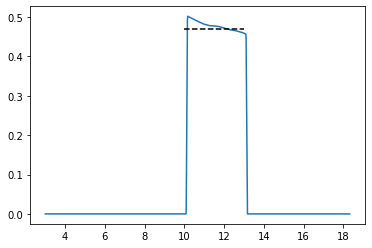

In [16]:
plt.plot(opt.tc_mirror.lam, opt.tc_mirror.val)
plt.plot([10, 13], [0.47, 0.47], 'k--')

The number of background photons that we get in the final produced image is

In [17]:
opt._gen_all_tc()
opt.n_ph_mirror

175981381.3646612

This number is $\sim 2\,\%$ lower than the number of emitted photons times the average transmission:

In [18]:
0.47 * opt._gen_thermal_emission()[1].photons_in_range()

178027272.46611667

## Generating the transmission curves one by one

We can construct the transmission curves of the individual components of the instrument separately. All of this is included in `OpticalTrain`, based on the configuration file. The plot shows the transmission curves.

In [19]:
TC_ELT = sim.spectral.TransmissionCurve("TC_mirror_total_emissivity.dat")

TC_window = sim.spectral.TransmissionCurve("TC_window_METIS.dat")

TC_dichroic_CFO = sim.spectral.TransmissionCurve("TC_dichroic_CFO.dat")

# TC pupil is 1

TC_CFO_mirrors = sim.spectral.TransmissionCurve("TC_mirror_aluminium.dat")

TC_CFO = TC_CFO_mirrors**19

TC_dichroic_IMG = sim.spectral.TransmissionCurve("TC_dichroic_IMG.dat")

TC_N2 = sim.spectral.TransmissionCurve("TC_filter_N2.dat")

#QE_AQUARIUS=sim.spectral.TransmissionCurve("TC_detector_METIS_NQ.dat")
QE_GeoSnap = sim.spectral.TransmissionCurve("TC_detector_METIS_NQ_no_losses.dat")

TC_total = TC_ELT * TC_window * TC_dichroic_CFO * TC_CFO * TC_dichroic_IMG * TC_N2 * QE_GeoSnap

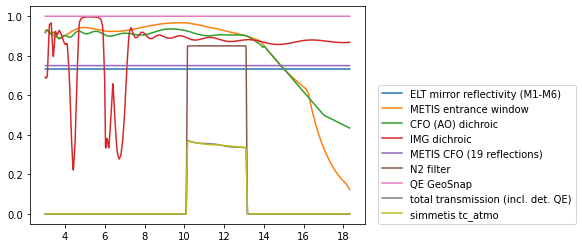

In [20]:
plt.plot(opt.tc_mirror.lam, TC_ELT, label="ELT mirror reflectivity (M1-M6)")
plt.plot(opt.tc_mirror.lam, TC_window, label="METIS entrance window")
plt.plot(opt.tc_mirror.lam, TC_dichroic_CFO, label="CFO (AO) dichroic")
plt.plot(opt.tc_mirror.lam, TC_dichroic_IMG, label="IMG dichroic")
plt.plot(opt.tc_mirror.lam, TC_CFO, label="METIS CFO (19 reflections)")
plt.plot(opt.tc_mirror.lam, TC_N2, label="N2 filter")
plt.plot(opt.tc_mirror.lam, QE_GeoSnap, label="QE GeoSnap")
plt.plot(opt.tc_mirror.lam, TC_total, label="total transmission (incl. det. QE)")
#plt.plot(opt.tc_mirror.lam,opt.tc_mirror,label="simmetis tc_mirror")
plt.plot(opt.tc_mirror.lam, opt.tc_atmo, label="simmetis tc_atmo")
plt.legend(loc=(1.04, 0))
plt.savefig("METIS_transmission_curves.png")

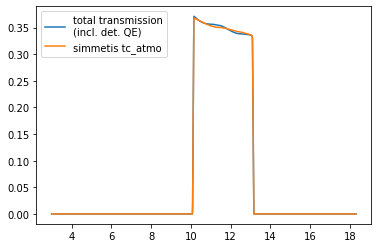

In [21]:
plt.plot(opt.tc_atmo.lam, TC_total, label="total transmission\n(incl. det. QE)")
plt.plot(opt.tc_atmo.lam, opt.tc_atmo, label="simmetis tc_atmo")
plt.legend(loc='best')

### Compute number of background photons in SimMETIS simulated image

We finally perform the simulation of chopped observations of the source defined above and measure source and background counts from the resulting images directly.

A simulation is performed in two steps. In the first step, the optical train is applied and a "clean" image is created. This is the ideal, noiseless image that is projected onto the focal-plane array. The image is stored as the `array` attribute of `fpa`. The second step reads out the detector and adds photon and detector noise to the image.

We store the noiseless image explicitely, scaled to the chosen exposure time. 

In [22]:
# Apply optical train (i.e. transmission, etc.)
src_chopA.apply_optical_train(opt, fpa)

dit = 1      # second
ndit = 1
exptime = dit * ndit

# Store noise-free image before Poisson noise is applied
photonflux = fpa.chips[0].array.T
clean_image = photonflux * exptime

# Read out the detector
hdu_A = fpa.read_out(OBS_DIT=dit, OBS_NDIT=ndit)

Generating image for chip 1
Reading out chip 1 using superfast
DIT = 1    NDIT = 1


In [23]:
# Repeat for chop position B
src_chopB.apply_optical_train(opt, fpa)
hdu_B = fpa.read_out(OBS_DIT=dit, OBS_NDIT=ndit)

Generating image for chip 1
Reading out chip 1 using superfast
DIT = 1    NDIT = 1


Visualise the chopped frames, the chop difference frame and the noiseless image:

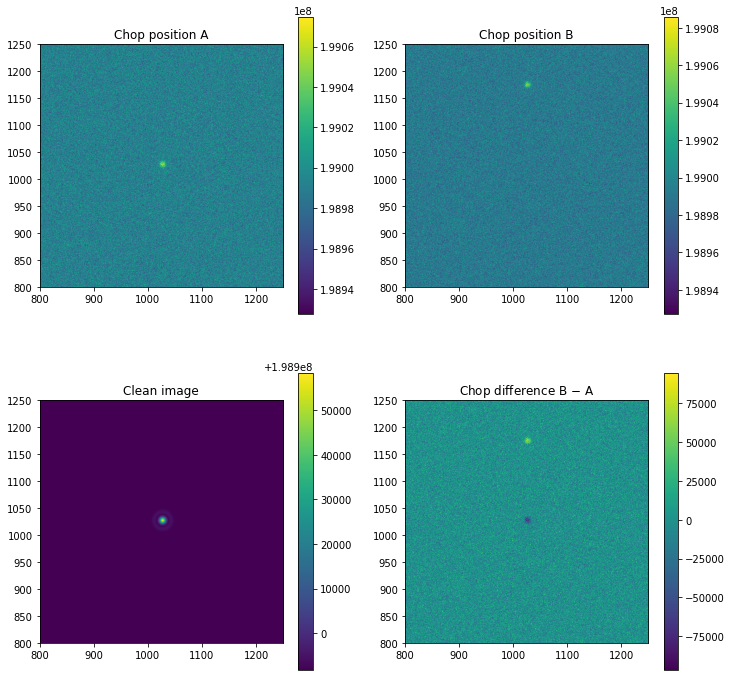

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
extent = xmin, xmax, ymin, ymax = 800, 1250, 800, 1250

vmin = clean_image.min()
vmax = clean_image.max()
imgA = hdu_A[0].data[ymin:ymax, xmin:xmax]
imgB = hdu_B[0].data[ymin:ymax, xmin:xmax]
imgAn = clean_image[ymin:ymax, xmin:xmax]
imgBA = imgB - imgA

# chop A frame
plot_A = axes[0, 0].imshow(imgA, origin='lower', extent=extent)
axes[0, 0].set_title("Chop position A")
fig.colorbar(plot_A, ax=axes[0, 0])

# chop B frame
plot_B = axes[0, 1].imshow(imgB, origin='lower', extent=extent)
axes[0, 1].set_title("Chop position B")
fig.colorbar(plot_B, ax=axes[0, 1])

# chop A frame without noise
plot_An = axes[1, 0].imshow(imgAn, origin='lower', vmin=vmin, vmax=vmax, extent=extent)
axes[1, 0].set_title("Clean image")
fig.colorbar(plot_An, ax=axes[1, 0])

# chop difference B-A frame
# This is the "final science-grade data product" in this simulation. Nodding is not required 
#    since it is only needed to correct for chop residuals, which we do not simulate.
plot_BA = axes[1, 1].imshow(imgBA, origin='lower', extent=extent)
axes[1, 1].set_title(r"Chop difference B $-$ A")
fig.colorbar(plot_BA, ax=axes[1, 1])

Save the chop difference image to disk. Unfortunately, there is currently no automatic way in SimMETIS to write this file with a proper FITS header. This will change in future versions with ScopeSim.

In [25]:
try:
    fits.writeto("chop_difference_BA.fits", data=imgB - imgA)
except OSError:
    print("The file already exists. Remove the file or change the file name in the line above.")

### Background photons

In [26]:
bgphotons_per_pix = np.median(hdu_A[0].data)

# Take into account background photons from the entrance window, not included in the simulation so far
bgphotons_per_pix *= 1.1

print("The number of bg counts per second per pix is {0:.2E}".format(bgphotons_per_pix))

The number of bg counts per second per pix is 2.19E+08


This number can be compared with 5.5e8 from Roy's doc (N2/median, Table 4, version 0.8), or 2.18e8 when adjusted to the GeoSnap pixel scale.

### Source photons

In [27]:
source_bgsubtracted = np.sum(clean_image - np.median(clean_image))
print("Bg-subtracted source photons (per s): {0:.2E}".format(source_bgsubtracted))

Bg-subtracted source photons (per s): 9.15E+06


This matches sufficiently well with the expected flux from Roy van Boekel, which is 3.95e10 for a 0 mag source, i.e. 9.92e6 for a 9 mag source.

### Compare to the number of photons to expect

In [28]:
# check sim.source.photons_to_mag

In [29]:
# A0V star of 0 mag corresponds to 30.072 Jy in N2 according to Roy, so for 9 mag we have
F = 30.072 * 10**(-0.4 * 9) * u.Jy
lam1 = 10.12 * u.micron
lam2 = 13.13 * u.micron
nu1 = const.c / lam1
nu2 = const.c / lam2
bandwidth_nu = -(nu2 - nu1)

In [30]:
e_ph = const.h * (0.5 * (nu2 + nu1))
N_ph = (F * 1*u.s * area_ELT * bandwidth_nu / e_ph).decompose()
N_ph # without transmission losses

<Quantity 30619879.04401723>

In [31]:
# including transmission losses -- it matches rougly with the numbers above (given)
## 0.36: total system transmission ELT+METIS of N2 filter / without atmospheric losses
## 0.6: detector QE (not included here for the time being)
print("{:.4g}".format(N_ph * 0.36))

1.102e+07


### Other tests

The transmission curve used. `tc_source` includes atmosphere; `tc_atmo` does not. This may be a bit confusing, but the naming convention is such that the tc includes all components downstream from the component in the name. Hence, `tc_atmo` includes all components that follow the atmosphere in the light path (the next one would be the telescope mirror). 

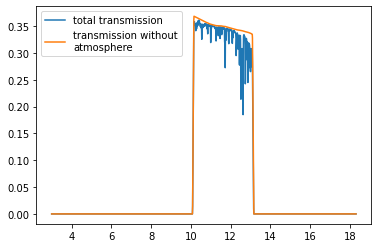

In [32]:
plt.plot(opt.tc_source.lam,opt.tc_source,label="total transmission")
plt.plot(opt.tc_atmo.lam,opt.tc_atmo, label="transmission without\natmosphere")
plt.legend()

The emission from the atmosphere looks like this:

(10.0, 13.0)

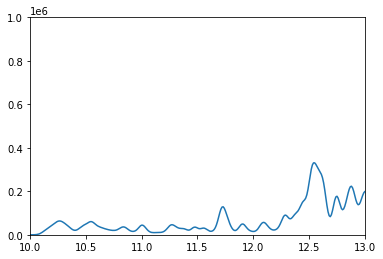

In [33]:
from scipy.ndimage.filters import gaussian_filter
plt.plot(opt.ph_atmo.lam, gaussian_filter(opt.ph_atmo, sigma=3))
plt.ylim([0, 1e6])
plt.xlim([10, 13])